In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from sklearn import mixture, metrics



Affichage des données du fichier sans traitement


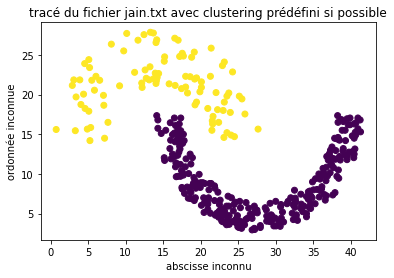



Affichage du clustering avec le modèle de mélange de Gaussiennes


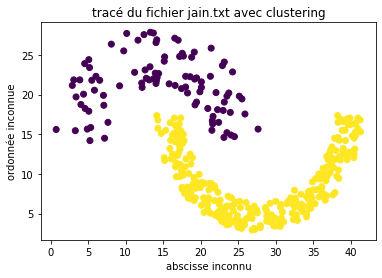

################


Pour le fichier jain.txt, l'indice de Rand est de : 1.0.
Le nombre de cluster recherché est de : 2
.
################


Affichage des données du fichier sans traitement


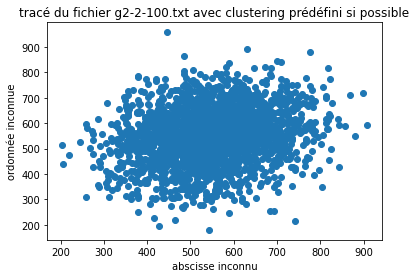



Affichage du clustering avec le modèle de mélange de Gaussiennes


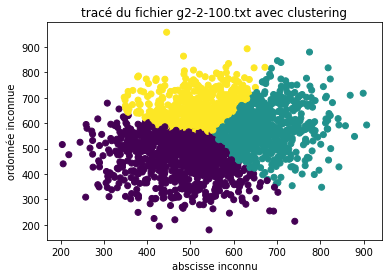

################

Il n'y a pas de classe prédéfinie pour le fichier g2-2-100.txt, l'indice de rand n'est donc pas calculable.
 Le nombre de cluster recherché est de : 3
.
################


Affichage des données du fichier sans traitement


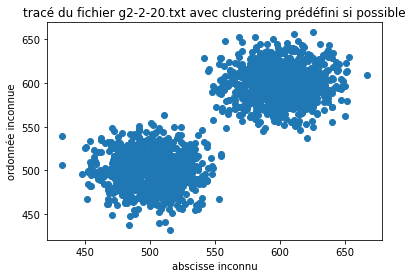



Affichage du clustering avec le modèle de mélange de Gaussiennes


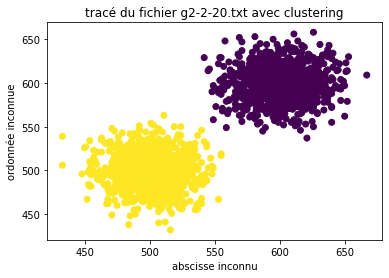

################

Il n'y a pas de classe prédéfinie pour le fichier g2-2-20.txt, l'indice de rand n'est donc pas calculable.
 Le nombre de cluster recherché est de : 2
.
################


Affichage des données du fichier sans traitement


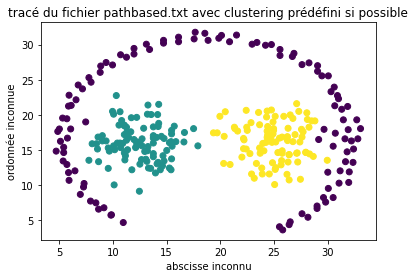



Affichage du clustering avec le modèle de mélange de Gaussiennes


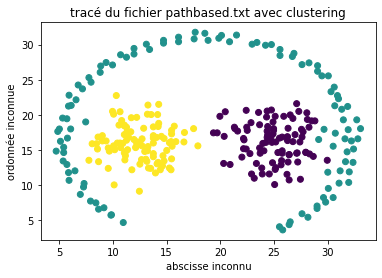

################


Pour le fichier pathbased.txt, l'indice de Rand est de : 1.0.
Le nombre de cluster recherché est de : 3
.
################


Affichage des données du fichier sans traitement


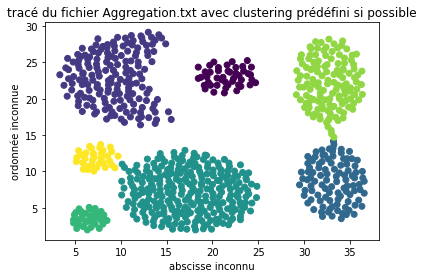



Affichage du clustering avec le modèle de mélange de Gaussiennes


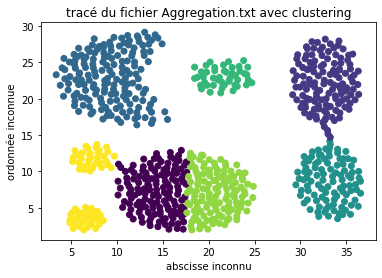

################


Pour le fichier Aggregation.txt, l'indice de Rand est de : 0.7920125813042513.
Le nombre de cluster recherché est de : 7
.
################


In [93]:
files = ["jain.txt", "g2-2-100.txt", "g2-2-20.txt", "pathbased.txt", "Aggregation.txt"]
cluster = [2, 3, 2, 3, 7]

for file in files :
    f_in = open("../src/"+file, "r")
    f_out = open("../src/"+file.replace(".txt", "")+"_out.txt", "w")
    for line in f_in :
        f_out.write(re.sub("\s+", ",", line.strip())+"\n")
    f_in.close()
    f_out.close()

compteur = 0
for file in files :

    print("\n\nAffichage des données du fichier sans traitement")

    data = pd.read_csv("../src/"+file[:-4]+"_out.txt")
    try :
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], c = data.iloc[:, 2])
    except :
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1])
    plt.title("tracé du fichier "+file+" avec clustering prédéfini si possible")
    plt.xlabel("abscisse inconnu")
    plt.ylabel("ordonnée inconnue")
    plt.show()

    print("\n\nAffichage du clustering avec le modèle de mélange de Gaussiennes")
    X_train = data
    gmm = mixture.GaussianMixture(n_components = cluster[compteur]).fit(X_train)
    labels = gmm.predict(X_train)
    plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c = labels)
    plt.title("tracé du fichier "+file+" avec clustering")
    plt.xlabel("abscisse inconnu")
    plt.ylabel("ordonnée inconnue")
    plt.show()

    try : 
        rand_value = metrics.adjusted_rand_score(data.iloc[:, 2], labels)
        print("################\n\n")
        print("Pour le fichier "+file+", l'indice de Rand est de : "+str(rand_value)+".\nLe nombre de cluster recherché est de : "+str(cluster[compteur]))
        print("\n################")
    except :
        print("################\n")
        print("Il n'y a pas de classe prédéfinie pour le fichier "+file+", l'indice de rand n'est donc pas calculable.\n Le nombre de cluster recherché est de : "+str(cluster[compteur]))
        print("\n################")

    compteur += 1

